  # Meta-World

  ## Introduction

  This tutorial demonstrates how to use the `trace` package to optimize a policy for a simulated robot performing a pick-and-place task.

  ## Setup and Installation

  This example requires [LLF-Bench](https://github.com/microsoft/LLF-Bench) in addition to `trace`. You can install them as follows

      git clone https://github.com/microsoft/LLF-Bench.git
      cd LLF-Bench
      pip install -e .[metaworld]

  Let's start by importing the necessary libraries.

In [ ]:
%pip install trace-opt

In [1]:
from autogen import config_list_from_json
import llfbench
import random
import numpy as np
import opto.trace as trace
from opto.optimizers import OptoPrime
from opto.trace.bundle import ExceptionNode
from opto.trace.errors import ExecutionError


  ## Environment Setup

  Define the environment and helper functions to parse observations.

In [2]:
def parse_obs(obs):
    """Parse the observation string into a dictionary of lists of floats."""
    import json

    obs = json.loads(obs)
    for key in obs:
        obs[key] = obs[key].replace("[", "").replace("]", "").split()
        obs[key] = [float(i) for i in obs[key]]
    return obs

class TracedEnv:
    def __init__(self, env_name, seed=0, relative=True):
        self.seed = seed
        self.env_name = env_name
        self.relative = relative
        self.init()

    def init(self):
        random.seed(self.seed)
        np.random.seed(self.seed)
        self.env = llfbench.make(self.env_name)
        self.env.reset(seed=self.seed)
        self.env.action_space.seed(self.seed)
        self.env.control_mode("relative" if self.relative else "absolute")
        self.obs = None

    @trace.bundle()
    def reset(self):
        """
        Reset the environment and return the initial observation and info.
        """
        obs, info = self.env.reset()
        obs["observation"] = parse_obs(obs["observation"])
        self.obs = obs
        return obs, info

    def step(self, action):
        try:
            control = action.data if isinstance(action, trace.Node) else action
            next_obs, reward, termination, truncation, info = self.env.step(control)
            next_obs["observation"] = parse_obs(next_obs["observation"])
            self.obs = next_obs
        except Exception as e:
            e_node = ExceptionNode(
                e,
                inputs={"action": action},
                description="[exception] The operator step raises an exception.",
                name="exception_step",
            )
            raise ExecutionError(e_node)

        @trace.bundle()
        def step(action):
            """
            Take action in the environment and return the next observation
            """
            return next_obs

        next_obs = step(action)
        return next_obs, reward, termination, truncation, info


  ## Rollout Function

  Define a function to perform a rollout using the current policy.

In [3]:
def rollout(env, horizon, controller):
    """Rollout a controller in an env for horizon steps."""
    traj = dict(observation=[], action=[], reward=[], termination=[], truncation=[], success=[], info=[])
    obs, info = env.reset()
    traj["observation"].append(obs)

    for t in range(horizon):
        controller_input = obs["observation"]
        error = None
        try:
            action = controller(controller_input)
            next_obs, reward, termination, truncation, info = env.step(action)
        except trace.ExecutionError as e:
            error = e
            break

        if error is None:
            traj["observation"].append(next_obs)
            traj["action"].append(action)
            traj["reward"].append(reward)
            traj["termination"].append(termination)
            traj["truncation"].append(truncation)
            traj["success"].append(info["success"])
            traj["info"].append(info)
            if termination or truncation or info["success"]:
                break
            obs = next_obs
    return traj, error


  ## Optimize using Trace

  Define the function to optimize the policy using the Trace package.

In [4]:
def optimize_policy(
    env_name,
    horizon,
    memory_size=5,
    n_optimization_steps=100,
    seed=0,
    relative=True,
    verbose=False,
    model="gpt-4-0125-preview",
):

    @trace.bundle(trainable=True)
    def controller(obs):
        """
        A feedback controller that computes the action based on the observation.

        Args:
            obs: (dict) The observation from the environment. Each key is a string (indicating a type of observation) and the value is a list of floats.
        Output:
            action: (list or nd.array) A 4-dimensional vector.
        """
        return [0, 0, 0, 0]

    config_list = config_list_from_json("OAI_CONFIG_LIST")
    config_list = [config for config in config_list if config["model"] == model]
    optimizer = OptoPrime(controller.parameters(), config_list=config_list, memory_size=memory_size)

    env = TracedEnv(env_name, seed=seed, relative=relative)

    successes = []
    returns = []
    print("Optimization Starts")
    for i in range(n_optimization_steps):
        env.init()
        traj, error = rollout(env, horizon, controller)

        if error is None:
            feedback = f"Success: {traj['success'][-1]}\nReturn: {sum(traj['reward'])}"
            target = traj["observation"][-1]["observation"]

            successes.append(traj["success"][-1])
            returns.append(sum(traj["reward"]))
        else:
            feedback = error.exception_node.create_feedback()
            target = error.exception_node

        # Add instruction from the LLFbench environment, which contains
        # information about the action space and problem background. The original instruction says
        # obsrvaiton is a json string. But here we've parsed it as a dict so we
        # update the instruction.
        instruction = traj["observation"][0]["instruction"].data
        infix = "You will get observations of the robot state "
        prefix, suffix = instruction.split(infix)
        keys = ", ".join(traj["observation"][0]["observation"].data.keys())
        suffix = suffix.replace("json strings.", f"dict, where the keys are {keys}.")

        # Add an task specific explanation; as the original instruction says
        # only it's a pick-place task, which is too vague. We clarify the task.
        assert env_name in ["llf-metaworld-pick-place-v2", "llf-metaworld-reach-v2"]
        if env_name == "llf-metaworld-pick-place-v2":
            hint = prefix + "The goal of the task is to pick up a puck and put it to a goal position. " + infix + suffix
        else:
            hint = prefix + infix + suffix

        optimizer.objective = hint + optimizer.default_objective

        optimizer.zero_feedback()
        optimizer.backward(target, feedback)
        optimizer.step(verbose=verbose)

        print(f"Iteration: {i}, Feedback: {feedback}, Parameter: {controller.parameter.data}")

    successes.append(traj["success"][-1])
    returns.append(sum(traj["reward"]))
    print("Final Returns:", sum(traj["reward"]))
    return successes, returns


  ## Execute the Optimization Process


In [5]:
successes, returns = optimize_policy(
    env_name="llf-metaworld-pick-place-v2",
    horizon=10,
    n_optimization_steps=30,
    memory_size=5,
    seed=0,
    relative=True,
    verbose='output',
    model="gpt-4-0125-preview"
)


/home/chinganc/miniconda3/envs/trace/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space maximum and minimum values are equal. Actual equal coordinates: [(36,), (37,), (38,)]
  logger.warn(
/home/chinganc/miniconda3/envs/trace/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/chinganc/miniconda3/envs/trace/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'str'>
  logger.warn(
/home/chinganc/miniconda3/envs/trace/lib/python3.8/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/home/chinganc/miniconda3/envs/trace/lib/py

Optimization Starts


/home/chinganc/miniconda3/envs/trace/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/chinganc/miniconda3/envs/trace/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'str'>
  logger.warn(


LLM response:
 {
  "reasoning": "The task requires adjusting the controller function to generate appropriate action vectors for a Sawyer robot to successfully perform a pick-place task. The feedback from the environment after each action suggests that the predefined controller, which consistently returns a zero vector [0, 0, 0, 0] for any observation, fails to guide the robot towards the goal position effectively. The repeated instruction from the feedback implies that the controller should calculate actions that move the robot arm towards a specific target, which in this case is hinted to be [-0.07, 0.68, 0.12, 0]. The continuous feedback suggesting a move toward these coordinates suggests that the robot needs to adjust its position relative to the puck and possibly close the gripper (though closing the gripper is not explicitly mentioned, it's implied as part of the pick and place task). Therefore, to correct the issue,  the controller's code must be modified to generate non-zero act

/home/chinganc/miniconda3/envs/trace/lib/python3.8/site-packages/metaworld/policies/policy.py:42: UserWarning: Constant(s) may be too high. Environments clip response to [-1, 1]
  warnings.warn(


LLM response:
 {
    "reasoning": "The instruction requires improving the controller for a Sawyer robot to perform a pick-place task more effectively, by adjusting the __code0 variable. The feedback throughout the execution suggests that the robot's arm movement and gripper state were not always optimal for achieving the task. Particularly, suggestions to 'keep the gripper closed' or 'open the gripper' indicate the fourth component of the action vector (controlling the gripper state) was often set incorrectly given the task phase (approaching the puck vs. moving the puck towards the goal). Additionally, the directional components of the action vectors sometimes did not align with an efficient path to the puck or the goal, as evidenced by feedback directing to aim towards specific poses. The feedback on the return variable demonstrates that the current logic in __code0, where it attempts to move towards the puck and then the goal with conditions based on proximity, needs refinement to b

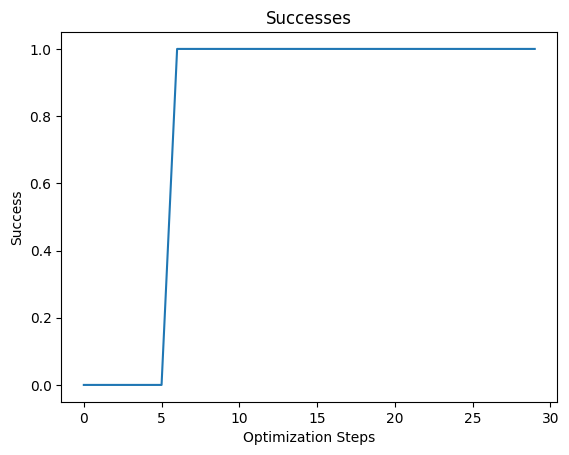

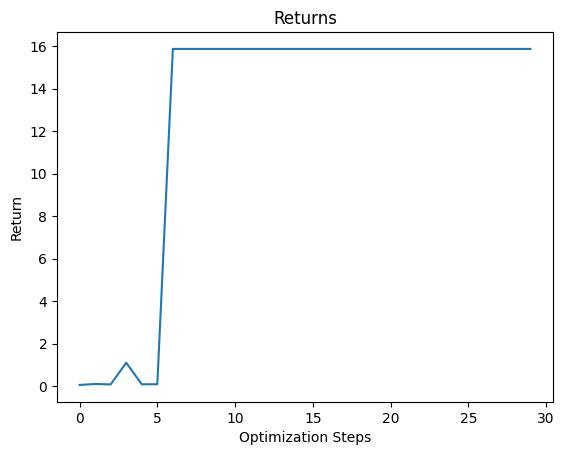

In [6]:
# plot successes, returns
import matplotlib.pyplot as plt
plt.plot(successes)
plt.xlabel("Optimization Steps")
plt.ylabel("Success")
plt.title("Successes")
plt.show()

plt.plot(returns)
plt.xlabel("Optimization Steps")
plt.ylabel("Return")
plt.title("Returns")
plt.show()


  This completes the tutorial on using the Trace package for optimizing codes in a multi-step RL environment.